In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [7]:
import gc
from multiprocessing import Process, Queue

import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

### Basics

In [ ]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")}')
    
    
def update_stocks_nc():
    os.system("rm mstncn.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/newconnect/mstock/mstncn.zip")
    #os.system("rm -rf data/*")
    os.system("unzip mstncn.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("CLOUD").index.max().strftime(format = "%Y-%m-%d")}')


def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')


def prepare_data(paper):

    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    try:
        df = store_stocks_dict[paper].copy()
    except:
        df = pd.read_csv(f'data/{paper}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()

    return df


def prepare_index(indeks):

    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')

    try:
        df = store_indexes_dict[indeks].copy()
    except:
        df = pd.read_csv(f'data_for/{indeks}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()

    return df

In [23]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

watch = ['PZU',
         'AMREST',
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW',
        'INTERCARS',
        'BIOMEDLUB',
        'PKOBP',
        'PEKAO',
        'SUNEX',
        'INTERCARS',
        'WIELTON']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

### Do updates

In [9]:
update_indexes()

Updated 2020-04-30, max actual date:     2020-04-28


In [11]:
update_stocks()

Updated 2020-04-30, max actual date:     2020-04-29


In [13]:
update_stocks_nc()

Updated 2020-04-30, max actual date:     2020-04-29


In [16]:
all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(
    f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}'
)

no of all available stock: 2399 and indexes: 23


## Single plot

### Plot code

In [20]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

### Just plot

In [17]:
[a for a in all_stocks if 'INTROL' in a]

['INTROL.mst']

In [18]:
papier = 'INTROL'

In [19]:
#plot_paper(papier,'2008-07-15','2008-11-15')

/home/showletter/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


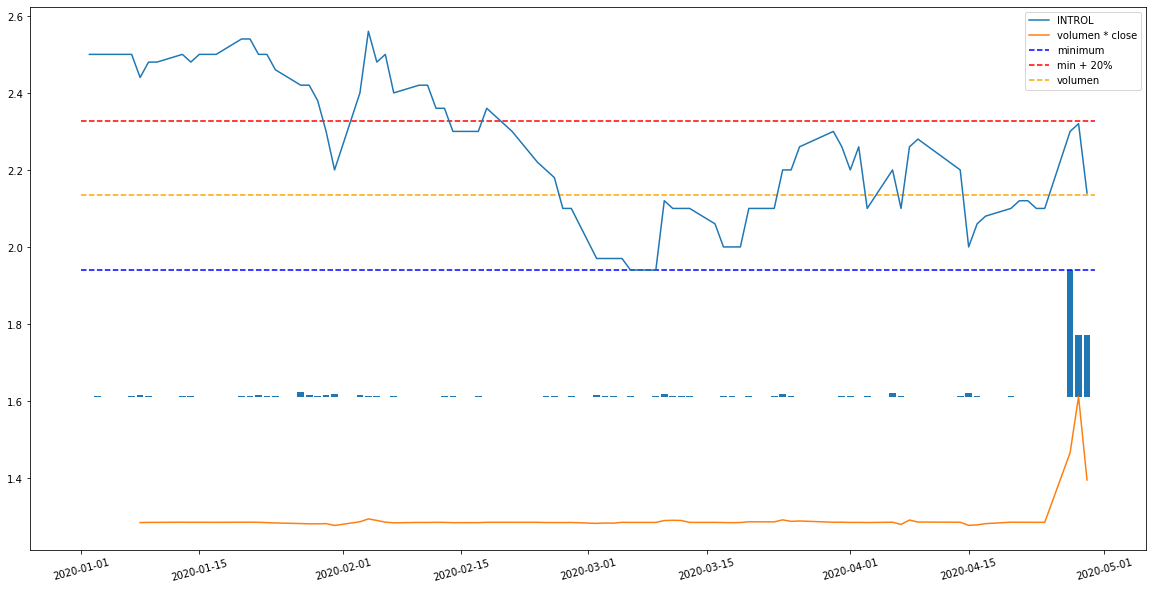

In [21]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [24]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: INTROL, currently at 2.14, with potential 19.63% to top
Max before crisis: 2.56
Crisis bottom: 1.94
Max after crisis drop: 2.32, at 2020-04-28 00:00:00
Stats after Max: [2.32 2.14]


## Skaner

In [25]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = [
    'ticker', 'current', 'mean_VOL', 'before_crisis', 'last_y_q', 'last_y_mid',
    'crisis_bottom', 'max_after_crisis', 'max_before_crisis'
]

### All papers

In [26]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index > '2019-10-01' ,'VOL'].mean(),
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 2399/2399 [00:15<00:00, 156.18it/s]


In [27]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [28]:
skaner_df_see = skaner_df.loc[
    #(skaner_df.growth_quarter > 0) 
        #& (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        #(skaner_df.growth_current > -100)
    (skaner_df.mean_VOL > 10000)
                              ,:].sort_values('drop_current', ascending=True)

In [29]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('DVP' in x)
                               | ('RCT' in x)
                               | ('RCS' in x)
                               | ('RCR' in x)
                               | ('RCB' in x)
                               | ('PBSK' in x)
                               | ('RCL' in x) else True).values,]

In [30]:
skaner_df_see.dropna().shape

(251, 15)

In [31]:
skaner_df_see.dropna().head(100)

,ticker,current,mean_VOL,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,growth_potential,drop_current
0,ITMTRADE,0.2280,2.179467e+04,1.270,2.2000,2.6000,0.2180,1.0900,2.2000,-42.27,-15.38,400.00,4.59,864.91,-89.64
0,ELBUDOWA,1.9500,1.035025e+05,7.680,6.2600,10.1000,1.2000,5.3000,9.2400,22.68,-38.02,341.67,62.50,373.85,-78.90
0,MABION,23.2500,3.404344e+04,51.100,80.0000,73.5000,17.9600,31.0000,103.6000,-36.12,8.84,72.61,29.45,345.59,-77.56
0,ALTUSTFI,0.6400,5.948789e+04,2.190,1.7200,2.1500,0.6400,1.2500,2.3000,27.33,-20.00,95.31,0.00,259.37,-72.17
0,BRASTER,0.3330,4.688440e+05,0.370,1.0400,1.7300,0.2000,0.4050,1.1620,-64.42,-39.88,102.50,66.50,248.95,-71.34
0,MOBIMEDIA,0.4000,1.672299e+05,0.725,0.4460,0.1290,0.2460,0.4000,1.2100,62.56,245.74,62.60,62.60,202.50,-66.94
0,SOLAR,3.5500,1.299997e+04,5.800,4.8800,5.1500,2.2000,3.6000,10.3000,18.85,-5.24,63.64,61.36,190.14,-65.53
0,CCC,46.5000,4.606560e+05,96.500,132.5000,153.9000,24.9800,47.0000,133.0000,-27.17,-13.91,88.15,86.15,186.02,-65.04
0,WORKSERV,0.4325,4.094649e+05,0.502,0.8600,2.2100,0.3420,0.4800,1.1440,-41.63,-61.09,40.35,26.46,164.51,-62.19
0,HERKULES,0.4720,1.770736e+04,0.860,1.1700,2.2200,0.4720,0.5900,1.2300,-26.50,-47.30,25.00,0.00,160.59,-61.63


## Model

In [32]:
### ADD WIG20 DAY BEFORE!

def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
#str strike
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5, 10, 20, 30, 60, 120, 240]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).mean()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
            
            df.loc[:,f'comp{i}d_std' + col] = df.loc[:,col].rolling(i).std()
            df.loc[:,f'comp{i}d_std' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_std' + col]) - 100
            
    
#     for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
#         cols = [f'comp{i}d_max' + col for i in [5,10,20]]
#         #df.loc[:,'all_higher_f'] = (df[cols] > 0).sum(axis = 1)
#         df.loc[:,'all_higher_cat'] = (df[cols] > 0).astype(str).sum(axis = 1)
        
#         cols = [f'comp{i}d_min' + col for i in [5,10,20]]
#         #df.loc[:,'all_lower_f'] = (df[cols] < 0).sum(axis = 1)
#         df.loc[:,'all_lower_cat'] = (df[cols] < 0).astype(str).sum(axis = 1)
    
            
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
### HISTORIC SECTION ###

    for a in [c for c in df.columns if ('diff_' in c) | ('chng' in c) | ('chng_' in c)]:
        for i in [1, 2, 3]:
            df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'roll{g}std_' + b] = df.loc[:,b].rolling(g).std()


### SUBTARGET ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'subtarget'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'subtarget'] = 0
            
### TARGET SECTION ###
#pick one the of the available sections

## HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0

### LOWER LOW ###
#     df.loc[df.loc[:, 'LOW'].shift(-1) < df.loc[:, 'LOW'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) >= df.loc[:, 'LOW'],'target'] = 0
    
### HIGHER OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) > df.loc[:, 'OPEN'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1),'target'] = 0

### OPENING NOT FAR FROM LOW ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 > df.loc[:, 'LOW'].shift(-1),'target'] = 0
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 <= df.loc[:, 'LOW'].shift(-1),'target'] = 1
    
### HIGH HIGHER MORE THAN 1% THAN OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 < df.loc[:, 'HIGH'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 >=  df.loc[:, 'HIGH'].shift(-1),'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###

    df.loc[:, 'max_5d'] = df.loc[:, 'CLOSE'].rolling(5).max()
    df.loc[df.loc[:, 'max_5d'].shift(-5) > df.loc[:, 'OPEN'].shift(-1)*1.1,'target'] = 1
    df.loc[df.loc[:, 'max_5d'].shift(-5) <= df.loc[:, 'OPEN'].shift(-1)*1.1,'target'] = 0
    
    return df
#ADD INDEX MEANS!
def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    
    for b in ['chng_OPEN', 'chng_LOW', 'chng_HIGH', 'chng_CLOSE', 'chng_VOL']:    
        for g in [2, 3, 5, 10, 20, 40, 80, 120, 240]:
            df.loc[:,f'idxroll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'idxroll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'idxroll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'idxroll{g}std_' + b] = df.loc[:,b].rolling(g).std()
    return df

In [33]:
def f(q, res):
    while not (q.empty()):
        pap = q.get()
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        df = df.dropna()
        res.put(df)
    #print('done')
    
    
def put_res_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [34]:
q = Queue()
res = Queue()
resfin = Queue()

papers_to_train = list(watch + list(skaner_df_see.dropna().ticker.values))
papers_to_train = list(dict.fromkeys(papers_to_train ))

for w in (papers_to_train):
    q.put(w)

In [35]:
full_size = q.qsize()
total = q.qsize()
pbar = tqdm(total = total)

p = Process(target=f, args=(q, res))
p2 = Process(target=f, args=(q, res))
p3 = Process(target=f, args=(q, res))
p4 = Process(target=f, args=(q, res))
#p5 = Process(target=f, args=(q, res))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


while (res.qsize() != full_size):
    if total > q.qsize():
        pbar.update(1)
        total = q.qsize()
pbar.close()

 99%|█████████▉| 256/258 [02:56<00:01,  1.45it/s]


In [36]:
pt = Process(target=put_res_together, args=(resfin, res))
pt2 = Process(target=put_res_together, args=(resfin, res))
pt3 = Process(target=put_res_together, args=(resfin, res))
pt4 = Process(target=put_res_together, args=(resfin, res))
pt.start()
pt2.start()
pt3.start()
pt4.start()

total = res.qsize()
pbar = tqdm(total = total)

while(res.qsize()):
    if total > res.qsize():
        pbar.update(1)
        total = res.qsize()
pbar.close()

100%|██████████| 258/258 [00:07<00:00, 36.30it/s]


In [37]:
df_merged = pd.DataFrame()

total = resfin.qsize()
pbar = tqdm(total = total)

while not resfin.empty():
    df = resfin.get()
    df_merged = pd.concat([df_merged, df])
    pbar.update(1)
pbar.close()

25it [00:28,  1.16s/it]                        


In [38]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

pt.terminate()
pt2.terminate()
pt3.terminate()
pt4.terminate()


gc.collect()

51

In [39]:
df_indexes_merged = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
    df = transform_one_index(df) 
    
    #df = df.dropna()
    
    df_indexes_merged = pd.concat([df_indexes_merged, df])
    del df

100%|██████████| 23/23 [00:16<00:00,  1.39it/s]


In [40]:
df_indexes_merged = df_indexes_merged.reset_index().groupby('DTYYYYMMDD').mean()
df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

idx_cols_chng = [c for c in df_indexes_merged.columns if 'chng' in c]

df_indexes_merged = df_indexes_merged.loc[:,idx_cols_chng]

df_indexes_merged = df_indexes_merged.dropna(how = 'all',axis = 1)

In [41]:
# df_indexes_merged = df_indexes_merged.pivot_table(index='DTYYYYMMDD', columns='TICKER', values='chng_CLOSE')
# df_indexes_merged = df_indexes_merged.agg(['mean', 'max', 'min', 'std'], axis = 1)
# df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

In [42]:
#df_merged = df_merged.drop([c for c in df_merged.columns if 'foreign_s' in c], axis = 1).copy()

In [43]:
df_merged = df_merged.merge(df_indexes_merged, left_index=True, right_index=True, how = 'left')

In [44]:
train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c) | ('hist' in c)]

#train_cols = train_cols + list(df_indexes_merged.columns)

#train_cols = ['all_lower_cat', 'all_higher_cat'] + train_cols

In [179]:
#train_cols = train_cols_limited

df = df_merged.copy()
#df = df.loc[df.index > '2007-01-01',:]

In [180]:
valid = df.loc[df.index >= '2020-03-01'].copy()

In [181]:
df = df.loc[df.index < '2020-03-01']

In [182]:
cut_date = '2019-11-01'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [188]:
def get_model():
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.02,
                               #bagging_temperature=3,
                               #random_strength = 3,
                               use_best_model=True,
                               min_data_in_leaf=200,
                               #sampling_frequency=1,
                               #subsample = 0.8,
                           depth=5,
                               has_time=True,
                          #thread_count=4,
                          eval_metric='AUC',
                          task_type='GPU')
    return model

In [189]:
model = get_model()

In [190]:
model.fit(train_data, train_labels, #cat_features=[0, 1],
          #eval_set=[(train_data[:-1], train_labels[:-1]),(eval_data[:-1], eval_labels[:-1])],
          eval_set=[(eval_data[:-1], eval_labels[:-1])],
         early_stopping_rounds=100, use_best_model=True)

0:	learn: 0.7548337	test: 0.7519670	best: 0.7519670 (0)	total: 19.5ms	remaining: 3m 15s
1:	learn: 0.7690645	test: 0.7619445	best: 0.7619445 (1)	total: 40.2ms	remaining: 3m 21s
2:	learn: 0.7781336	test: 0.7657935	best: 0.7657935 (2)	total: 60.6ms	remaining: 3m 21s
3:	learn: 0.7808299	test: 0.7695996	best: 0.7695996 (3)	total: 80.8ms	remaining: 3m 21s
4:	learn: 0.7835419	test: 0.7718432	best: 0.7718432 (4)	total: 101ms	remaining: 3m 22s
5:	learn: 0.7838696	test: 0.7719701	best: 0.7719701 (5)	total: 121ms	remaining: 3m 21s
6:	learn: 0.7845446	test: 0.7719201	best: 0.7719701 (5)	total: 139ms	remaining: 3m 18s
7:	learn: 0.7854918	test: 0.7721482	best: 0.7721482 (7)	total: 160ms	remaining: 3m 19s
8:	learn: 0.7860104	test: 0.7727409	best: 0.7727409 (8)	total: 179ms	remaining: 3m 18s
9:	learn: 0.7866227	test: 0.7729372	best: 0.7729372 (9)	total: 197ms	remaining: 3m 16s
10:	learn: 0.7867201	test: 0.7727017	best: 0.7729372 (9)	total: 215ms	remaining: 3m 15s
11:	learn: 0.7865890	test: 0.7730033	b

105:	learn: 0.7968811	test: 0.7793345	best: 0.7793345 (105)	total: 1.93s	remaining: 2m 59s
106:	learn: 0.7969486	test: 0.7792469	best: 0.7793345 (105)	total: 1.95s	remaining: 2m 59s
107:	learn: 0.7969879	test: 0.7792175	best: 0.7793345 (105)	total: 1.96s	remaining: 2m 59s
108:	learn: 0.7970302	test: 0.7792383	best: 0.7793345 (105)	total: 1.98s	remaining: 2m 59s
109:	learn: 0.7970669	test: 0.7792768	best: 0.7793345 (105)	total: 2s	remaining: 3m
110:	learn: 0.7971479	test: 0.7793769	best: 0.7793769 (110)	total: 2.02s	remaining: 2m 59s
111:	learn: 0.7971674	test: 0.7793406	best: 0.7793769 (110)	total: 2.04s	remaining: 2m 59s
112:	learn: 0.7972461	test: 0.7793565	best: 0.7793769 (110)	total: 2.06s	remaining: 2m 59s
113:	learn: 0.7972778	test: 0.7793891	best: 0.7793891 (113)	total: 2.07s	remaining: 2m 59s
114:	learn: 0.7973681	test: 0.7794638	best: 0.7794638 (114)	total: 2.09s	remaining: 2m 59s
115:	learn: 0.7974542	test: 0.7795612	best: 0.7795612 (115)	total: 2.11s	remaining: 2m 59s
116:	l

200:	learn: 0.8010312	test: 0.7808248	best: 0.7808248 (200)	total: 3.6s	remaining: 2m 55s
201:	learn: 0.8010454	test: 0.7808177	best: 0.7808248 (200)	total: 3.62s	remaining: 2m 55s
202:	learn: 0.8010972	test: 0.7808128	best: 0.7808248 (200)	total: 3.64s	remaining: 2m 55s
203:	learn: 0.8011158	test: 0.7808311	best: 0.7808311 (203)	total: 3.65s	remaining: 2m 55s
204:	learn: 0.8011264	test: 0.7808356	best: 0.7808356 (204)	total: 3.67s	remaining: 2m 55s
205:	learn: 0.8011921	test: 0.7808216	best: 0.7808356 (204)	total: 3.69s	remaining: 2m 55s
206:	learn: 0.8012254	test: 0.7808644	best: 0.7808644 (206)	total: 3.71s	remaining: 2m 55s
207:	learn: 0.8012553	test: 0.7808551	best: 0.7808644 (206)	total: 3.73s	remaining: 2m 55s
208:	learn: 0.8012687	test: 0.7808882	best: 0.7808882 (208)	total: 3.74s	remaining: 2m 55s
209:	learn: 0.8012919	test: 0.7808991	best: 0.7808991 (209)	total: 3.76s	remaining: 2m 55s
210:	learn: 0.8013290	test: 0.7809242	best: 0.7809242 (210)	total: 3.78s	remaining: 2m 55s


296:	learn: 0.8041112	test: 0.7818813	best: 0.7818813 (296)	total: 5.25s	remaining: 2m 51s
297:	learn: 0.8041191	test: 0.7818795	best: 0.7818813 (296)	total: 5.27s	remaining: 2m 51s
298:	learn: 0.8041372	test: 0.7818979	best: 0.7818979 (298)	total: 5.29s	remaining: 2m 51s
299:	learn: 0.8041450	test: 0.7819177	best: 0.7819177 (299)	total: 5.3s	remaining: 2m 51s
300:	learn: 0.8041548	test: 0.7818834	best: 0.7819177 (299)	total: 5.32s	remaining: 2m 51s
301:	learn: 0.8041862	test: 0.7818696	best: 0.7819177 (299)	total: 5.34s	remaining: 2m 51s
302:	learn: 0.8042084	test: 0.7819030	best: 0.7819177 (299)	total: 5.36s	remaining: 2m 51s
303:	learn: 0.8042254	test: 0.7819211	best: 0.7819211 (303)	total: 5.37s	remaining: 2m 51s
304:	learn: 0.8042579	test: 0.7818950	best: 0.7819211 (303)	total: 5.39s	remaining: 2m 51s
305:	learn: 0.8043126	test: 0.7818972	best: 0.7819211 (303)	total: 5.4s	remaining: 2m 51s
306:	learn: 0.8043461	test: 0.7818943	best: 0.7819211 (303)	total: 5.42s	remaining: 2m 51s
3

393:	learn: 0.8063375	test: 0.7827268	best: 0.7827392 (391)	total: 6.92s	remaining: 2m 48s
394:	learn: 0.8063798	test: 0.7827255	best: 0.7827392 (391)	total: 6.94s	remaining: 2m 48s
395:	learn: 0.8063856	test: 0.7827410	best: 0.7827410 (395)	total: 6.96s	remaining: 2m 48s
396:	learn: 0.8064059	test: 0.7827474	best: 0.7827474 (396)	total: 6.97s	remaining: 2m 48s
397:	learn: 0.8064242	test: 0.7827752	best: 0.7827752 (397)	total: 6.99s	remaining: 2m 48s
398:	learn: 0.8064451	test: 0.7827734	best: 0.7827752 (397)	total: 7.01s	remaining: 2m 48s
399:	learn: 0.8064764	test: 0.7827896	best: 0.7827896 (399)	total: 7.03s	remaining: 2m 48s
400:	learn: 0.8065057	test: 0.7827888	best: 0.7827896 (399)	total: 7.04s	remaining: 2m 48s
401:	learn: 0.8065370	test: 0.7827806	best: 0.7827896 (399)	total: 7.06s	remaining: 2m 48s
402:	learn: 0.8065503	test: 0.7828121	best: 0.7828121 (402)	total: 7.08s	remaining: 2m 48s
403:	learn: 0.8065545	test: 0.7828084	best: 0.7828121 (402)	total: 7.09s	remaining: 2m 48s

490:	learn: 0.8081622	test: 0.7834705	best: 0.7834714 (488)	total: 8.58s	remaining: 2m 46s
491:	learn: 0.8081796	test: 0.7835140	best: 0.7835140 (491)	total: 8.6s	remaining: 2m 46s
492:	learn: 0.8082004	test: 0.7835136	best: 0.7835140 (491)	total: 8.62s	remaining: 2m 46s
493:	learn: 0.8082071	test: 0.7835154	best: 0.7835154 (493)	total: 8.63s	remaining: 2m 46s
494:	learn: 0.8082457	test: 0.7835088	best: 0.7835154 (493)	total: 8.65s	remaining: 2m 46s
495:	learn: 0.8082615	test: 0.7835091	best: 0.7835154 (493)	total: 8.66s	remaining: 2m 46s
496:	learn: 0.8083022	test: 0.7834889	best: 0.7835154 (493)	total: 8.68s	remaining: 2m 46s
497:	learn: 0.8083380	test: 0.7835047	best: 0.7835154 (493)	total: 8.7s	remaining: 2m 46s
498:	learn: 0.8083528	test: 0.7835129	best: 0.7835154 (493)	total: 8.72s	remaining: 2m 46s
499:	learn: 0.8083763	test: 0.7835070	best: 0.7835154 (493)	total: 8.73s	remaining: 2m 45s
500:	learn: 0.8083901	test: 0.7835256	best: 0.7835256 (500)	total: 8.75s	remaining: 2m 45s
5

587:	learn: 0.8100549	test: 0.7836919	best: 0.7838182 (539)	total: 10.2s	remaining: 2m 43s
588:	learn: 0.8100785	test: 0.7836750	best: 0.7838182 (539)	total: 10.3s	remaining: 2m 43s
589:	learn: 0.8101203	test: 0.7836388	best: 0.7838182 (539)	total: 10.3s	remaining: 2m 43s
590:	learn: 0.8101438	test: 0.7836462	best: 0.7838182 (539)	total: 10.3s	remaining: 2m 43s
591:	learn: 0.8101502	test: 0.7836453	best: 0.7838182 (539)	total: 10.3s	remaining: 2m 43s
592:	learn: 0.8101598	test: 0.7836516	best: 0.7838182 (539)	total: 10.3s	remaining: 2m 43s
593:	learn: 0.8101787	test: 0.7836483	best: 0.7838182 (539)	total: 10.3s	remaining: 2m 43s
594:	learn: 0.8101912	test: 0.7836604	best: 0.7838182 (539)	total: 10.4s	remaining: 2m 43s
595:	learn: 0.8101981	test: 0.7836658	best: 0.7838182 (539)	total: 10.4s	remaining: 2m 43s
596:	learn: 0.8102059	test: 0.7836724	best: 0.7838182 (539)	total: 10.4s	remaining: 2m 43s
597:	learn: 0.8102257	test: 0.7836602	best: 0.7838182 (539)	total: 10.4s	remaining: 2m 43s

685:	learn: 0.8115504	test: 0.7838196	best: 0.7838657 (652)	total: 11.9s	remaining: 2m 41s
686:	learn: 0.8115584	test: 0.7838104	best: 0.7838657 (652)	total: 11.9s	remaining: 2m 41s
687:	learn: 0.8115656	test: 0.7838159	best: 0.7838657 (652)	total: 11.9s	remaining: 2m 41s
688:	learn: 0.8115756	test: 0.7838171	best: 0.7838657 (652)	total: 12s	remaining: 2m 41s
689:	learn: 0.8115850	test: 0.7838328	best: 0.7838657 (652)	total: 12s	remaining: 2m 41s
690:	learn: 0.8116006	test: 0.7838336	best: 0.7838657 (652)	total: 12s	remaining: 2m 41s
691:	learn: 0.8116236	test: 0.7838513	best: 0.7838657 (652)	total: 12s	remaining: 2m 41s
692:	learn: 0.8116332	test: 0.7838214	best: 0.7838657 (652)	total: 12s	remaining: 2m 41s
693:	learn: 0.8116438	test: 0.7838219	best: 0.7838657 (652)	total: 12s	remaining: 2m 41s
694:	learn: 0.8116545	test: 0.7838310	best: 0.7838657 (652)	total: 12.1s	remaining: 2m 41s
695:	learn: 0.8116758	test: 0.7838200	best: 0.7838657 (652)	total: 12.1s	remaining: 2m 41s
696:	learn:

782:	learn: 0.8129783	test: 0.7839394	best: 0.7839831 (779)	total: 13.5s	remaining: 2m 39s
783:	learn: 0.8129887	test: 0.7839544	best: 0.7839831 (779)	total: 13.6s	remaining: 2m 39s
784:	learn: 0.8129985	test: 0.7839631	best: 0.7839831 (779)	total: 13.6s	remaining: 2m 39s
785:	learn: 0.8130060	test: 0.7839685	best: 0.7839831 (779)	total: 13.6s	remaining: 2m 39s
786:	learn: 0.8130277	test: 0.7839713	best: 0.7839831 (779)	total: 13.6s	remaining: 2m 39s
787:	learn: 0.8130433	test: 0.7839811	best: 0.7839831 (779)	total: 13.6s	remaining: 2m 39s
788:	learn: 0.8130578	test: 0.7839817	best: 0.7839831 (779)	total: 13.7s	remaining: 2m 39s
789:	learn: 0.8130784	test: 0.7839838	best: 0.7839838 (789)	total: 13.7s	remaining: 2m 39s
790:	learn: 0.8130843	test: 0.7839778	best: 0.7839838 (789)	total: 13.7s	remaining: 2m 39s
791:	learn: 0.8130938	test: 0.7839924	best: 0.7839924 (791)	total: 13.7s	remaining: 2m 39s
792:	learn: 0.8131016	test: 0.7840048	best: 0.7840048 (792)	total: 13.7s	remaining: 2m 39s

879:	learn: 0.8143425	test: 0.7839860	best: 0.7840199 (836)	total: 15.2s	remaining: 2m 37s
880:	learn: 0.8143481	test: 0.7839856	best: 0.7840199 (836)	total: 15.2s	remaining: 2m 37s
881:	learn: 0.8143610	test: 0.7839689	best: 0.7840199 (836)	total: 15.2s	remaining: 2m 37s
882:	learn: 0.8143670	test: 0.7839818	best: 0.7840199 (836)	total: 15.3s	remaining: 2m 37s
883:	learn: 0.8143766	test: 0.7839987	best: 0.7840199 (836)	total: 15.3s	remaining: 2m 37s
884:	learn: 0.8143868	test: 0.7839906	best: 0.7840199 (836)	total: 15.3s	remaining: 2m 37s
885:	learn: 0.8144143	test: 0.7839857	best: 0.7840199 (836)	total: 15.3s	remaining: 2m 37s
886:	learn: 0.8144249	test: 0.7839999	best: 0.7840199 (836)	total: 15.3s	remaining: 2m 37s
887:	learn: 0.8144359	test: 0.7839947	best: 0.7840199 (836)	total: 15.3s	remaining: 2m 37s
888:	learn: 0.8144431	test: 0.7839966	best: 0.7840199 (836)	total: 15.4s	remaining: 2m 37s
889:	learn: 0.8144577	test: 0.7839784	best: 0.7840199 (836)	total: 15.4s	remaining: 2m 37s

977:	learn: 0.8155657	test: 0.7840707	best: 0.7841136 (970)	total: 16.9s	remaining: 2m 35s
978:	learn: 0.8155948	test: 0.7840682	best: 0.7841136 (970)	total: 16.9s	remaining: 2m 35s
979:	learn: 0.8156058	test: 0.7840697	best: 0.7841136 (970)	total: 16.9s	remaining: 2m 35s
980:	learn: 0.8156368	test: 0.7840714	best: 0.7841136 (970)	total: 16.9s	remaining: 2m 35s
981:	learn: 0.8156571	test: 0.7840689	best: 0.7841136 (970)	total: 16.9s	remaining: 2m 35s
982:	learn: 0.8156713	test: 0.7840838	best: 0.7841136 (970)	total: 16.9s	remaining: 2m 35s
983:	learn: 0.8156844	test: 0.7840818	best: 0.7841136 (970)	total: 17s	remaining: 2m 35s
984:	learn: 0.8156965	test: 0.7840631	best: 0.7841136 (970)	total: 17s	remaining: 2m 35s
985:	learn: 0.8157070	test: 0.7840894	best: 0.7841136 (970)	total: 17s	remaining: 2m 35s
986:	learn: 0.8157182	test: 0.7840854	best: 0.7841136 (970)	total: 17s	remaining: 2m 35s
987:	learn: 0.8157256	test: 0.7840832	best: 0.7841136 (970)	total: 17s	remaining: 2m 35s
988:	lear

1075:	learn: 0.8167974	test: 0.7843668	best: 0.7844112 (1069)	total: 18.5s	remaining: 2m 33s
1076:	learn: 0.8168078	test: 0.7843461	best: 0.7844112 (1069)	total: 18.5s	remaining: 2m 33s
1077:	learn: 0.8168181	test: 0.7843589	best: 0.7844112 (1069)	total: 18.5s	remaining: 2m 33s
1078:	learn: 0.8168284	test: 0.7843737	best: 0.7844112 (1069)	total: 18.6s	remaining: 2m 33s
1079:	learn: 0.8168368	test: 0.7843820	best: 0.7844112 (1069)	total: 18.6s	remaining: 2m 33s
1080:	learn: 0.8168544	test: 0.7843764	best: 0.7844112 (1069)	total: 18.6s	remaining: 2m 33s
1081:	learn: 0.8168606	test: 0.7843642	best: 0.7844112 (1069)	total: 18.6s	remaining: 2m 33s
1082:	learn: 0.8168702	test: 0.7843662	best: 0.7844112 (1069)	total: 18.6s	remaining: 2m 33s
1083:	learn: 0.8168902	test: 0.7843837	best: 0.7844112 (1069)	total: 18.7s	remaining: 2m 33s
1084:	learn: 0.8169010	test: 0.7843499	best: 0.7844112 (1069)	total: 18.7s	remaining: 2m 33s
1085:	learn: 0.8169171	test: 0.7843403	best: 0.7844112 (1069)	total: 1

1173:	learn: 0.8179652	test: 0.7843597	best: 0.7844181 (1106)	total: 20.2s	remaining: 2m 31s
1174:	learn: 0.8179708	test: 0.7843634	best: 0.7844181 (1106)	total: 20.2s	remaining: 2m 31s
1175:	learn: 0.8179879	test: 0.7843730	best: 0.7844181 (1106)	total: 20.2s	remaining: 2m 31s
1176:	learn: 0.8179923	test: 0.7843808	best: 0.7844181 (1106)	total: 20.2s	remaining: 2m 31s
1177:	learn: 0.8180006	test: 0.7843742	best: 0.7844181 (1106)	total: 20.2s	remaining: 2m 31s
1178:	learn: 0.8180098	test: 0.7843825	best: 0.7844181 (1106)	total: 20.3s	remaining: 2m 31s
1179:	learn: 0.8180161	test: 0.7843921	best: 0.7844181 (1106)	total: 20.3s	remaining: 2m 31s
1180:	learn: 0.8180254	test: 0.7843994	best: 0.7844181 (1106)	total: 20.3s	remaining: 2m 31s
1181:	learn: 0.8180380	test: 0.7843945	best: 0.7844181 (1106)	total: 20.3s	remaining: 2m 31s
1182:	learn: 0.8180436	test: 0.7843838	best: 0.7844181 (1106)	total: 20.3s	remaining: 2m 31s
1183:	learn: 0.8180565	test: 0.7844014	best: 0.7844181 (1106)	total: 2

1271:	learn: 0.8190821	test: 0.7844425	best: 0.7845015 (1243)	total: 21.8s	remaining: 2m 29s
1272:	learn: 0.8190917	test: 0.7844394	best: 0.7845015 (1243)	total: 21.8s	remaining: 2m 29s
1273:	learn: 0.8190974	test: 0.7844650	best: 0.7845015 (1243)	total: 21.9s	remaining: 2m 29s
1274:	learn: 0.8191089	test: 0.7844631	best: 0.7845015 (1243)	total: 21.9s	remaining: 2m 29s
1275:	learn: 0.8191200	test: 0.7844740	best: 0.7845015 (1243)	total: 21.9s	remaining: 2m 29s
1276:	learn: 0.8191390	test: 0.7844649	best: 0.7845015 (1243)	total: 21.9s	remaining: 2m 29s
1277:	learn: 0.8191497	test: 0.7844801	best: 0.7845015 (1243)	total: 21.9s	remaining: 2m 29s
1278:	learn: 0.8191563	test: 0.7844830	best: 0.7845015 (1243)	total: 21.9s	remaining: 2m 29s
1279:	learn: 0.8191588	test: 0.7844774	best: 0.7845015 (1243)	total: 22s	remaining: 2m 29s
1280:	learn: 0.8191659	test: 0.7844806	best: 0.7845015 (1243)	total: 22s	remaining: 2m 29s
1281:	learn: 0.8191763	test: 0.7844671	best: 0.7845015 (1243)	total: 22s	r

In [191]:
model.get_feature_importance(prettified=True).head(50)

,Feature Id,Importances
0,roll240std_chng_HIGH,5.986908
1,roll120std_chng_HIGH,5.350146
2,roll240std_chng_OPEN,4.518938
3,roll80std_chng_HIGH,3.782501
4,roll240std_chng_CLOSE,2.965604
5,roll40std_chng_HIGH,1.737391
6,roll120std_chng_CLOSE,1.639221
7,roll120max_chng_OPEN,1.591153
8,foreign_stocks_idxroll80max_chng_LOW,1.417418
9,roll240max_chng_HIGH,1.348627


In [192]:
working_feats_785_on_high = ['diff_HIGH_CLOSE', 'diff_OPEN_CLOSE','roll20min_diff_LOW_HIGH',
                     'chng_HIGH','roll2std_chng_HIGH',
                     'comp5d_stdHIGH','roll20min_chng_VOL','comp5d_meanOPEN','move_strength_abs',
                     'roll2min_chng_HIGH','roll3min_move_strength_abs']

imp = model.get_feature_importance(prettified=True)
train_cols_limited  = [c for c in train_cols if c in imp.loc[imp.Importances >= 0.01, 'Feature Id'].values]
#train_cols_limited = working_feats_785_on_high
len(train_cols) - len(train_cols_limited)

39

### Check performance

In [193]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

preds = preds_class[:-1].astype(int)

In [199]:
preds = preds_proba[:,1].copy()

preds[preds > 0.6] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [200]:
confusion_matrix(eval_labels[:-1].astype(int), preds)

array([[16249,     8],
       [ 2169,    23]])

In [201]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(16249, 8, 2169, 23)

In [202]:
(tn + tp) / (tn + tp + fp + fn)

0.8819990243373624

In [203]:
tp / (tp + fp)

0.7419354838709677

In [204]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.897793,0.102207
1.0,0.770012,0.229988


In [205]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)
df_res_grouped = df_res.drop('zero', axis = 1)

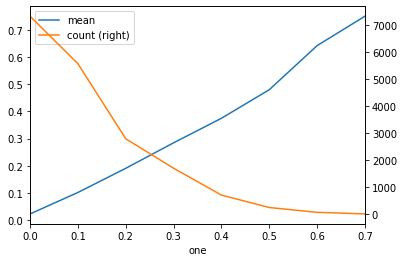

In [206]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [207]:
df_res_grouped

,mean,count
one,,
0.0,0.023294,7341
0.1,0.102132,5581
0.2,0.190987,2796
0.3,0.284624,1704
0.4,0.374823,707
0.5,0.479675,246
0.6,0.641791,67
0.7,0.750000,8


#### Check valid

In [208]:
valid_data = valid.loc[:,train_cols]
valid_labels = valid.loc[:,'target'].values

preds_class = model.predict(valid_data)
# Get predicted probabilities for each class

preds = preds_class[:-1].astype(int)

In [214]:
preds_proba = model.predict_proba(valid_data)

preds = preds_proba[:,1].copy()

preds[preds > 0.6] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [215]:
confusion_matrix(valid_labels[:-1].astype(int), preds)

array([[6493,   27],
       [2071,   55]])

In [216]:
tn, fp, fn, tp = confusion_matrix(valid_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(6493, 27, 2071, 55)

In [217]:
(tn + tp) / (tn + tp + fp + fn)

0.7573444367337497

In [218]:
tp / (tp + fp)

0.6707317073170732

### Prediction

In [219]:
def transform_results(qpapers, qtransformed, model):
    while not (qpapers.empty()):
        pap = qpapers.get()
        #print(pap)
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        
        df = df.merge(df_indexes_merged,
              left_index=True,
              right_index=True,
              how='left')

        #df.loc[:, 'pred_class'] = model.predict(df[train_cols])
        df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

        df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
        df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
        df.loc[:, 'fut_LOW'] = df.loc[:, 'LOW'].shift(-1)
        df.loc[:, 'fut_HIGH'] = df.loc[:, 'HIGH'].shift(-1)
        
        df.loc[:, 'fut5_CLOSE'] = df.loc[:, 'CLOSE'].shift(-5)
        df.loc[:, 'max_5d'] = df.loc[:, 'CLOSE'].rolling(5).max()
        
        df.loc[:, 'fut10_CLOSE'] = df.loc[:, 'CLOSE'].shift(-10)
        df.loc[:, 'max_10d'] = df.loc[:, 'CLOSE'].rolling(10).max()
        
        df.loc[:, 'fOPEN_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'fOPEN_fCLOSE_chng'] = (df.loc[:, 'fut_CLOSE'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'CLOSE_fOPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
                                         df.loc[:, 'CLOSE']) - 100
        df.loc[:, 'HIGH_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                         df.loc[:, 'HIGH']) - 100
        df.loc[:, 'LOW_fLOW_chng'] = (df.loc[:, 'fut_LOW'] * 100 /
                 df.loc[:, 'LOW']) - 100
        
        df.loc[:, 'fOPEN_f10CLOSE_chng'] = (df.loc[:, 'fut10_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f10MAX_chng'] = (df.loc[:, 'max_10d'].shift(-10) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5CLOSE_chng'] = (df.loc[:, 'fut5_CLOSE'] * 100 /
             df.loc[:, 'fut_OPEN']) - 100
        
        df.loc[:, 'fOPEN_f5MAX_chng'] = (df.loc[:, 'max_5d'].shift(-5) * 100 /
             df.loc[:, 'fut_OPEN']) - 100
    

        one_res = df.reset_index().loc[:, [
            'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 
           'fut_OPEN', 'fut_LOW', 'fut_HIGH', 'fut_CLOSE', 'fOPEN_fHIGH_chng', 
            'fOPEN_fCLOSE_chng', 'CLOSE_fOPEN_chng', 'HIGH_fHIGH_chng', 'LOW_fLOW_chng', 
            'fOPEN_f5CLOSE_chng', 'fOPEN_f5MAX_chng',
            'fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng', 'pred_prob']
                                      ].tail(30)
    
        #if one_res.shape == (15, 16):
        qtransformed.put(one_res)
    
    
def put_res_results_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [220]:
qpapers = Queue()
qtransformed = Queue()

for w in (skaner_df_see.dropna().ticker.values):
    qpapers.put(w)

In [221]:
total = qpapers.qsize()
full_size = qpapers.qsize()

#%%time
p = Process(target=transform_results, args=(qpapers, qtransformed, model))
p2 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p3 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p4 = Process(target=transform_results, args=(qpapers, qtransformed, model))
#p5 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p.start()
p2.start()
p3.start()
p4.start()
#p5.start()


pbar = tqdm(total = total)

while not qpapers.empty():
    if total > qpapers.qsize():
        pbar.update(1)
        #print(total)
        total = qpapers.qsize()
pbar.close()

 98%|█████████▊| 246/251 [02:55<00:03,  1.40it/s]


In [222]:
qtransformed.qsize()

251

In [223]:
res = pd.DataFrame()
for i in tqdm(range(qtransformed.qsize())):
    df = qtransformed.get()
    #print(df.TICKER.values[0])
    res = pd.concat([res, df])
    #print(res.shape)

100%|██████████| 251/251 [00:00<00:00, 897.29it/s]


In [224]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
#p5.terminate()

### Prediction results

In [225]:
res.loc[:,'DTYYYYMMDD'] = pd.to_datetime(res.DTYYYYMMDD)

In [226]:
res.loc[res.DTYYYYMMDD == '2020-04-20'].sort_values('pred_prob', ascending=False).tail(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,fut_OPEN,fut_LOW,fut_HIGH,fut_CLOSE,fOPEN_fHIGH_chng,fOPEN_fCLOSE_chng,CLOSE_fOPEN_chng,HIGH_fHIGH_chng,LOW_fLOW_chng,fOPEN_f5CLOSE_chng,fOPEN_f5MAX_chng,fOPEN_f10CLOSE_chng,fOPEN_f10MAX_chng,pred_prob
611,2020-04-20,PGO,0.870,0.850,0.890,0.890,0.890,0.870,0.920,0.880,3.370787e+00,-1.123596,0.000000e+00,3.370787,2.352941,-2.696629,5.617978,NaN,NaN,0.182860
3089,2020-04-20,CIGAMES,0.757,0.699,0.757,0.720,0.710,0.640,0.710,0.662,0.000000e+00,-6.760563,-1.388889e+00,-6.208719,-8.440629,0.140845,0.140845,NaN,NaN,0.182686
2790,2020-04-20,BUMECH,2.400,2.320,2.530,2.500,2.530,2.300,2.580,2.580,1.976285e+00,1.976285,1.200000e+00,1.976285,-0.862069,-1.185771,4.743083,NaN,NaN,0.179754
1499,2020-04-20,LIVECHAT,55.000,52.400,55.000,53.500,54.200,51.800,54.200,53.800,0.000000e+00,-0.738007,1.308411e+00,-1.454545,-1.145038,2.214022,2.214022,NaN,NaN,0.178901
2083,2020-04-20,MEDICALG,24.900,22.850,24.900,24.500,24.500,22.550,24.900,23.650,1.632653e+00,-3.469388,0.000000e+00,0.000000,-1.312910,-2.857143,-2.040816,NaN,NaN,0.178865
1400,2020-04-20,TORPOL,7.780,7.620,7.960,7.740,7.660,7.040,7.660,7.340,0.000000e+00,-4.177546,-1.033592e+00,-3.768844,-7.611549,0.000000,0.522193,NaN,NaN,0.178263
2177,2020-04-20,SELVITA,36.500,33.600,36.500,35.000,35.000,33.000,35.000,34.600,0.000000e+00,-1.142857,0.000000e+00,-4.109589,-1.785714,3.428571,3.428571,NaN,NaN,0.175365
6584,2020-04-20,SANPL,157.000,154.100,160.300,158.700,156.500,151.900,158.100,152.000,1.022364e+00,-2.875399,-1.386263e+00,-1.372427,-1.427644,-7.220447,-2.236422,NaN,NaN,0.174956
3029,2020-04-20,ASBIS,3.360,3.320,3.440,3.350,3.360,3.035,3.410,3.200,1.488095e+00,-4.761905,2.985075e-01,-0.872093,-8.584337,-1.785714,-1.785714,NaN,NaN,0.173352
2861,2020-04-20,QUERCUS,2.650,2.480,2.650,2.510,2.480,2.320,2.490,2.450,4.032258e-01,-1.209677,-1.195219e+00,-6.037736,-6.451613,8.870968,10.887097,NaN,NaN,0.172803


In [227]:
res.loc[res.DTYYYYMMDD == '2020-04-29'].sort_values('pred_prob', ascending=False).head(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,fut_OPEN,fut_LOW,fut_HIGH,fut_CLOSE,fOPEN_fHIGH_chng,fOPEN_fCLOSE_chng,CLOSE_fOPEN_chng,HIGH_fHIGH_chng,LOW_fLOW_chng,fOPEN_f5CLOSE_chng,fOPEN_f5MAX_chng,fOPEN_f10CLOSE_chng,fOPEN_f10MAX_chng,pred_prob
848,2020-04-29,JWA,0.210,0.2000,0.2200,0.2150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.572925
1782,2020-04-29,ITMTRADE,0.190,0.1900,0.2390,0.2280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.544285
1542,2020-04-29,NFPL,0.222,0.2051,0.2400,0.2051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.461967
1490,2020-04-29,MERLINGRP,0.300,0.3000,0.3100,0.3100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.391076
1732,2020-04-29,AITON,0.350,0.3300,0.3500,0.3500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.379196
391,2020-04-29,HORNIGOLD,0.122,0.1120,0.1230,0.1215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.353616
1151,2020-04-29,IGORIA,0.163,0.1410,0.1870,0.1870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351606
1400,2020-04-29,FABRYKAKD,0.106,0.1060,0.1270,0.1270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.319058
2401,2020-04-29,MABION,22.850,21.1500,23.6000,23.2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.317410
795,2020-04-29,TERMO2PWR,0.238,0.2220,0.2450,0.2400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.315862


In [99]:
last_day = res.loc[res.DTYYYYMMDD == '2020-04-28'].sort_values('pred_prob', ascending=False)

In [100]:
#res.TICKER.apply(lambda x: True if 'INTROL' in x else False).sum()

In [101]:
last_day.mean()

OPEN                   849.608922
LOW                    843.313429
HIGH                   859.788148
CLOSE                  848.889667
fut_OPEN               873.879131
fut_LOW                869.564100
fut_HIGH               893.948975
fut_CLOSE              890.529872
fOPEN_fHIGH_chng         4.135661
fOPEN_fCLOSE_chng        1.698743
CLOSE_fOPEN_chng         0.565024
HIGH_fHIGH_chng          1.189896
LOW_fLOW_chng            0.757448
fOPEN_f5CLOSE_chng            NaN
fOPEN_f5MAX_chng              NaN
fOPEN_f10CLOSE_chng           NaN
fOPEN_f10MAX_chng             NaN
pred_prob                0.145324
dtype: float64

In [103]:
last_day.loc[last_day.pred_prob > 0.4].mean()

OPEN                    0.202333
LOW                     0.187000
HIGH                    0.222333
CLOSE                   0.205333
fut_OPEN                0.187667
fut_LOW                 0.177000
fut_HIGH                0.215333
fut_CLOSE               0.210000
fOPEN_fHIGH_chng       15.091768
fOPEN_fCLOSE_chng      12.368293
CLOSE_fOPEN_chng       -8.285474
HIGH_fHIGH_chng        -2.988991
LOW_fLOW_chng          -5.782546
fOPEN_f5CLOSE_chng           NaN
fOPEN_f5MAX_chng             NaN
fOPEN_f10CLOSE_chng          NaN
fOPEN_f10MAX_chng            NaN
pred_prob               0.457870
dtype: float64

In [104]:
res_see = res.sort_values('pred_prob', ascending=False).copy()
res_see = res_see.drop_duplicates()
res_see.loc[res_see.pred_prob > 0.5].groupby('DTYYYYMMDD').mean().mean()

OPEN                    0.971457
LOW                     0.863073
HIGH                    1.007695
CLOSE                   0.895499
fut_OPEN                0.931994
fut_LOW                 0.884324
fut_HIGH                1.021575
fut_CLOSE               0.953153
fOPEN_fHIGH_chng        7.732249
fOPEN_fCLOSE_chng       4.948149
CLOSE_fOPEN_chng        0.141431
HIGH_fHIGH_chng         0.570030
LOW_fLOW_chng           1.771719
fOPEN_f5CLOSE_chng     20.179991
fOPEN_f5MAX_chng       31.790949
fOPEN_f10CLOSE_chng    40.149455
fOPEN_f10MAX_chng      64.200138
pred_prob               0.563024
dtype: float64

In [105]:
res_see.loc[:,'pred_prob_rounded'] = res_see.pred_prob.round(1)

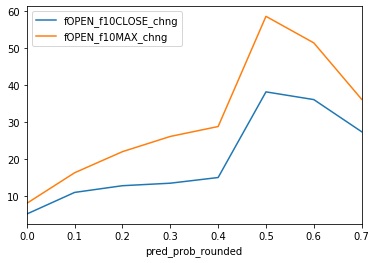

In [106]:
res_see.groupby('pred_prob_rounded').mean()[['fOPEN_f10CLOSE_chng', 'fOPEN_f10MAX_chng']].plot()

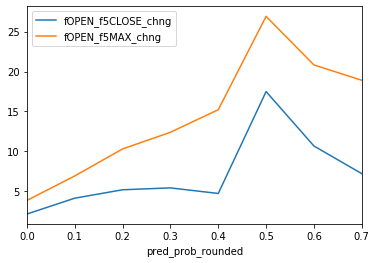

In [107]:
res_see.groupby('pred_prob_rounded').mean()[['fOPEN_f5CLOSE_chng', 'fOPEN_f5MAX_chng']].plot()

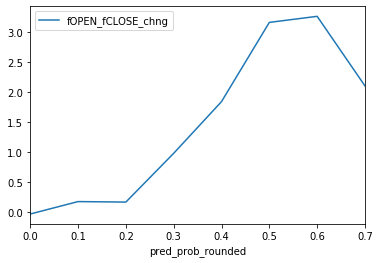

In [109]:
res_see.groupby('pred_prob_rounded').mean()[['fOPEN_fCLOSE_chng']].plot()

## Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
